In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from data.data import Data
from models.double_mlp import DoubleMLPEstimator
from tqdm.notebook import tqdm
from wrap.stats import est_theta, exp_stats
from wrap.utils import torch_to_np, train_test_split


p = 20
n = 200
rho = 0
theta = 10
lamb = 1

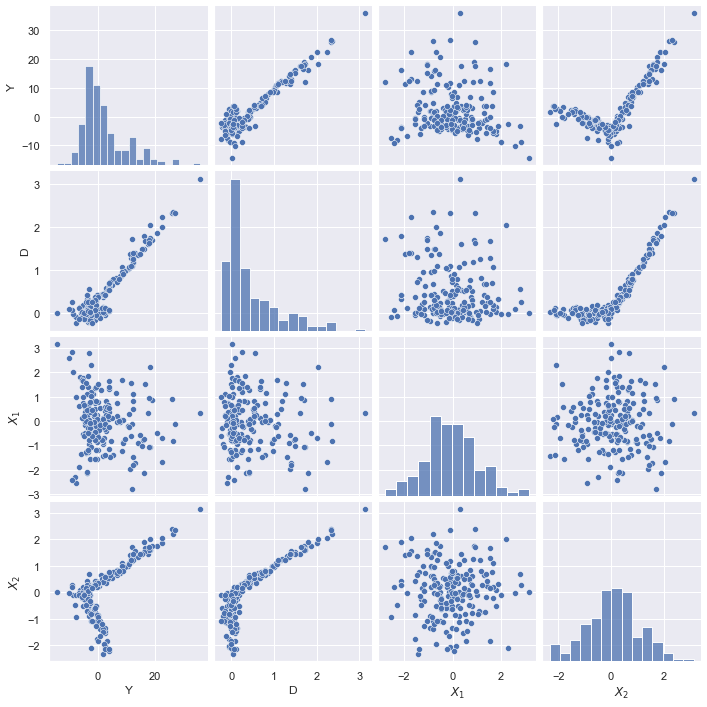

In [2]:
true_model = Data(p, rho, theta, lamb)

n_plot = 200
Y, D, X = true_model.generate(n_plot)
Y, D, X = torch_to_np(Y), torch_to_np(D), torch_to_np(X)

df = pd.DataFrame(data=np.concatenate((Y.reshape(n_plot, 1), D.reshape(n_plot, 1), X[:, 0:2]), 1), 
                  columns=['Y', 'D', '$X_1$', '$X_2$'])
sns.set(font_scale=1)
sns.pairplot(df)
sns.set(rc={'figure.figsize': (10, 10)})
plt.savefig('results/pairs_' + str(theta) + '_.pdf', bbox_inches="tight")
plt.show()

In [3]:
def run_experiments(theta, gammas, num_exp=10):
    lamb = 1.
    df = pd.DataFrame()
    for gamma in tqdm(gammas):
        for i in range(num_exp):
            true_model = Data(p, rho, theta, lamb)
            y, d, x = true_model.generate(n)
            train, test = train_test_split(y, d, x)
            
            # Estimate l_hat + m_hat
            bbox = DoubleMLPEstimator(true_model, train['x'].shape[1]+1, hidden_dims=(32, 32, 32),
                                      activation_params=dict(negative_slope=0.1))
            _, dm, dl = bbox.fit(train['x'], train['d'], train['y'], reg_labmda=gamma)
            m_hat, l_hat = bbox.predict(test['x'], test['d'])
            
            # Statistics
            theta_hat, v2 = est_theta(test['y'], test['d'], m_hat, l_hat)
            
            df_tmp = pd.DataFrame({
                'model' : ['mlp'],
                'rho' : rho,
                'lamb' : lamb,
                'theta' : theta,
                'dtheta' : theta_hat - theta,
                'gamma' : gamma,
                'dm.2' : dm ** 2,
                'dl.2' : dl ** 2,
                'dm.dl': dm * dl,  
            })
            df = pd.concat([df, df_tmp])
    
    return df

In [4]:
gammas = np.logspace(-3, 2, num=6)
df = run_experiments(theta, gammas, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'gamma', 'theta']).mean().reset_index()

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
def plot_results(df, axs, key):
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        df_tmp[key].plot.hist(alpha=0.5, ax=axs, label='{:.1e}'.format(gamma))     

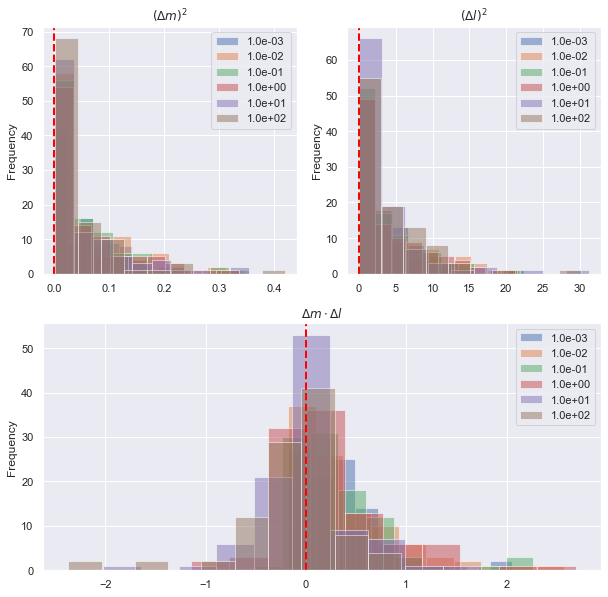

In [6]:
fig = plt.figure(figsize=(10,10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0,0])
plot_results(df, axs, 'dm.2')
axs.set_title('$(\\Delta m)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[0,1])
plot_results(df, axs, 'dl.2')
axs.set_title('$(\\Delta l)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[1,:])
plot_results(df, axs, 'dm.dl')
axs.set_title('$\\Delta m \cdot \\Delta l$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

plt.savefig('results/diagnostic_internal_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()

In [7]:
def get_bias(df):
    bias = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        bias.append(df_tmp['dtheta'].mean())
    return np.asarray(bias)

def get_variance(df):
    variance = []
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        variance.append(df_tmp['dtheta'].var())
    return np.asarray(variance)

bias = get_bias(df) 
variance = get_variance(df)

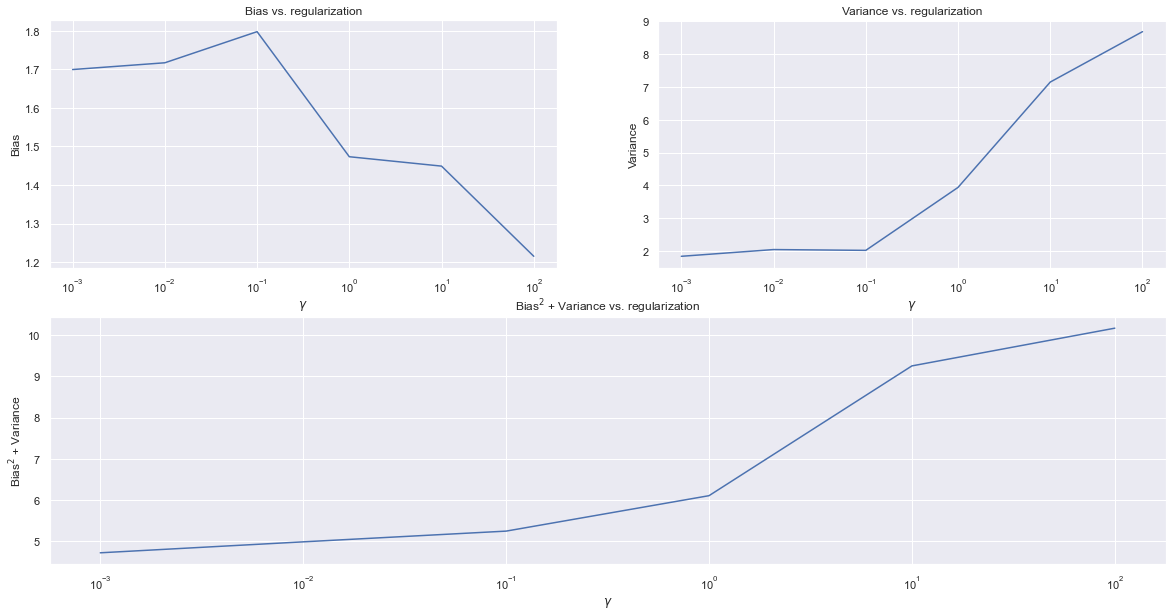

In [8]:
fig = plt.figure(figsize=(20, 10))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0, 0])
axs.plot(gammas, bias)
axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias')
axs.set_title('Bias vs. regularization')

axs = fig.add_subplot(grid[0, 1])
axs.plot(gammas, variance)
axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Variance')
axs.set_title('Variance vs. regularization')


axs = fig.add_subplot(grid[1, :])
axs.plot(gammas, bias ** 2 + variance)
axs.set_xscale('log')
axs.set_xlabel('$\\gamma$')
axs.set_ylabel('Bias$^2$ + Variance')
axs.set_title('Bias$^2$ + Variance vs. regularization')

plt.savefig('results/diagnostic_external_' + str(theta) + '_.pdf', bbox_inches='tight')
plt.show()